# Transfer Leanring

Transfer learning is the process f taking what was learned from another and applying it our current problem



In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


Now we have the versions of torch and torchvisision we need, let's import some code from previous sections so we don't have to re-write it

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 29.90 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [3]:
# set device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1 Get Data

We need our pizza steak sushi data to build our transfer learning model on

In [4]:
import os
import zipfile

from pathlib import Path
import requests

# setup data path
data_path = Path('data')
image_path = data_path / 'pizza_steak_sushi'

# if the image folder doesn't exist, download it
if image_path.is_dir():
  print(f'{image_path} directory already exists')
else:
  print(f"Didn't find {image_path} downloading it")
  image_path.mkdir(parents=True, exist_ok=True)

  # download pizz steak sushi data
  with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
    print("Downloading data...")
    f.write(request.content)

  # Unzip data
  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping data')
    zip_ref.extractall(image_path)

  # remove zip file
  os.remove(data_path / 'pizza_steak_sushi.zip')
  print('Done!')

Didn't find data/pizza_steak_sushi downloading it
Unzipping data
Done!


In [5]:
# setup directories
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2 Create Datasets and DataLoaders

Now we have some data, we want to turn it into pytorch DataLoaders

To do so, we can use `data_setup.py` and the `create_dataloaders()` we made in 04_going_modular

One thing to think about when loading data is how to transfomr it and with torchvision 0.13+ there are two ways to do this:

1. manually created transform - you define what transforms you want your data to go through
2. automatically created transform - the transforms for your data are defined for the model yo want to use

**Important Point:** When using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed** in the same way as the data used to train that model

### 2.1 Creating transforms for torchvision models (manual creation)

In [6]:
from going_modular.going_modular import data_setup

In [7]:
from torchvision import datasets, transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor(),
    normalize
])

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir= test_dir,
                                                                               transform = manual_transform,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b3cbb572350>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision models (auto creation)



In [9]:
# get a set of pretrained model weights
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Best availiable weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# get the transforms used to create the weights
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# create dataloaders with automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir= test_dir,
                                                                               transform = auto_transform,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b3cbb586510>,
 ['pizza', 'steak', 'sushi'])

## 3 Getting a pretrained model
There are various ways of getting pretrainined models:
1. PyTorch domain libraies
2. Libraies like `tim` (torch image models)
3. Hugginface Hub (for plenty of different models)
4. Paperwithcode (for models across many domains)

### 3.1. Whih model shoudl you choose

Experiment, experiment, experiment

The whole point of transfer learning is to take an already well-performing model from a problem space similar to your own and then customize it to your own problem

Three things to consider
1. Speed - how fast the model runs
2. Size - how big is the model
3. Performance - how well does the model perform

Where does the model live?
On device, or on a server

For our case (deploying food vision min on a mobile device), it looks like EfficientNetB0 is one of our best options in terms of performance vs size

However, in light of the Bitter Lesson, if we had infinte compute, we'd likely pick the biggest model + most general params we could

### 3.2 Setting up a Pretrained Model

Want to create an instance of EffNet B0

In [12]:
# creating the model
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 163MB/s]


In [13]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a Summary of our model with `torchinfo`

In [14]:
# print a summary with torchinfo
from torchinfo import summary
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base Model and Changing the Ouput Layer to suit our needs

With a Feature Extraction Model, typically you would 'freeze' the base layers of the pretrained model and update the output layers to suit your own problem

In [15]:
# freeze all base layers
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False


In [16]:
# update classifier head to suit our

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)


model.classifier


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [17]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4 Train Model

In [18]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)

In [19]:
# import train function
from going_modular.going_modular import engine

In [20]:
# set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

# setu training and save results
results = engine.train(model=model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

end_time = timer()
print(f'(INFO) Total Train Time: {end_time - start_time} ')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
(INFO) Total Train Time: 18.478716688000006 


## 5 Evaluate Model by plotting Loss Curves

Could not find helper_functions.py Downloading FIle


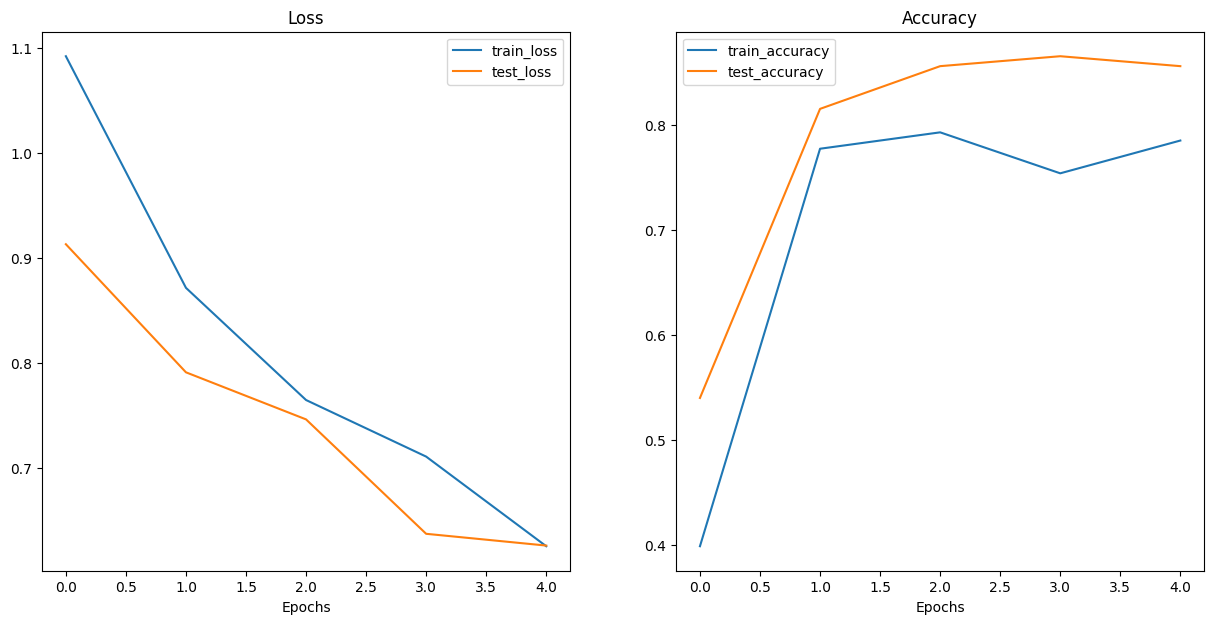

In [21]:
try:
  from helper_functions import plot_loss_curves
except:
  print('Could not find helper_functions.py Downloading FIle')
  with open('helper_functions.py', 'wb') as f:
    import requests
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/helper_functions.py')
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot loss curves
plot_loss_curves(results)

## 6 Make Predixtions on images from the test set

Let's adhere to the data exploere's moto of *Visualize visualize visualize*

And make some qualitative predictions on the test set

Some things to keep in mind when making predicctions/inference on test/custom data

We have to make sure that our test/custom data is:
* same shape as the model was trained on
* Same datatype - custom data should be in the same datatype
* Same device - data must be on the same device
* Same transform - if you transformed your training data, you would want to transform your test data in the same way

To do all of this automatically, let's create a function called `pred_and_plot()`

1. Take in a trained model, a list of class names, a filepath to the targe image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to evaluation mode
6. Transform the target image and make sure its dimensionality is suitable for the model
7. Make a prediction on the image
8. Convert the model's output to probabilities
9. Convert model's probbilities to predictions
10. Plot the image with matplotlib


In [22]:
from PIL import Image
import numpy as np

def pred_and_plot_image(image_file: str,
                     model: nn.Module,
                     transform: transforms.Compose = None,
                     device: str = device):
  # convert img file to tensor
  loaded_image = load_image(image_file)

  # transform tensor
  if transform:
    transformed_image = transform(loaded_image)
  else:
    transformed_image = transform_image(loaded_image)

  # make prediction
  pred = get_label(transformed_image, model)

  # plot results
  plot_results(label=pred, image = loaded_image)


def load_image(image_file: str) -> Image:
  img = Image.open(image_file)
  return img

def transform_image(image: Image) -> torch.Tensor:

  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

  transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      normalize
  ])

  transformed_image = transform(image)
  return transformed_image.type(torch.float32)

def get_label(image: torch.Tensor,
                    model: nn.Module,
                    device: str = device) -> torch.Tensor:

  model.to(device)
  model.eval()
  with torch.inference_mode():
    logits = model(image.unsqueeze(0).to(device))
    probs = torch.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim =1)
  label = class_names[pred]
  return label

def plot_results(label: str, image: Image):
  label = label
  plt.imshow(image)
  plt.title(f'Prediction: {label.upper()}')
  plt.axis(False)


In [23]:
import random
torch.manual_seed(42)

image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
img = Image.open(random_image_path)


In [24]:
# img

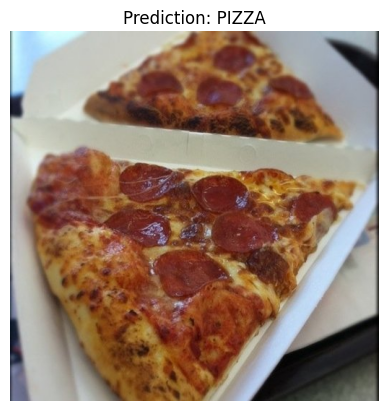

In [25]:
pred_and_plot_image(random_image_path,
                 model=model,
                 transform=manual_transform,
                 device=device)


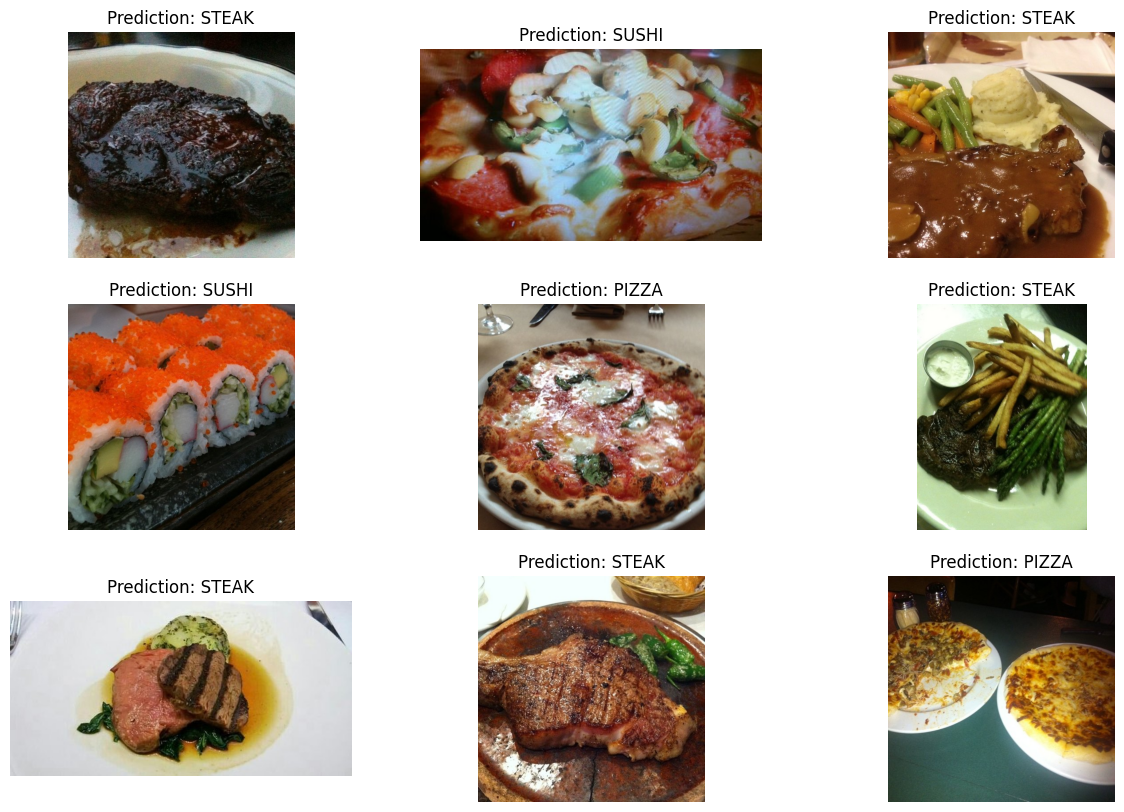

In [26]:
torch.manual_seed(42)

random_paths = random.choices(image_path_list, k= 9)
plt.figure(figsize=(15,10))
for i, path in enumerate(random_paths):

  fig = plt.subplot(3,3,i+1)
  pred_and_plot_image(path,
                 model=model,
                 transform=manual_transform,
                 device=device)


